In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from imblearn.over_sampling import SMOTE 
from sklearn.feature_selection import SelectKBest, f_classif, chi2
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score, classification_report, accuracy_score, plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import pickle
from flask import Flask, request, jsonify, render_template

# 1 -
## Link to article: https://www.kaggle.com/code/bhavyasriyarlagadda/heart-stroke-prediction

## 1st new technique: Forward Filling
### Forward filling means fill missing values with previous data, so NaNs get replaced with the value before, whether that be from the same row previous column or from same column previous row. 
### It should be used when dealing with the null values in a dataset, and the advantages of using this compared to just deleting the null values is that it can make that otherwise deleted data usable for interpretation and analysis.
## 2nd new technique: NearMiss Algorithm
### While SMOTE is an oversampling technique, in which the minority class becomes duplicated or new artificial data becomes created for the minority class, NearMiss is an undersampling technique, in which the majority class has data merged or deleted. It is usually implemented with near-neighbor methods in order to classify what data should be merged or deleted from the majority class based on distance from the minority class. 
### This is used when the target variable is unbalanced, and the advantages of using it is that it makes sure that the data is still mostly natural instead of artificially created from oversampling.
## 3rd new technique: Pipeline Creation
### Pipelines are a sequence of functions to process data, to help automate machine learning. The way used here is make_pipeline, in which naming is done automatically. As seen by the pipeline in the article, StandardScaler and RandomTreeClassifier run without having names. The pipeline in the article takes fitted data through standardization before being applied to a RandomTreeClassifier, in which the pipeline can be called for prediction. The advantages of doing this is it streamlines data processing before machine learning. 
### For example, if someone wanted to make predictions of a dataFrame based on means of columns that then are standardized, they could set up a pipeline that first gets the mean of each column, then standardizes each mean, then applies the model.

# 2 -
## Improvement 1:
### Scatterplots could be improved in readability (maybe increasing the plot size, changing opacity, or explaining what exactly each part of code does.)
## Improvement 2:
### Looking for outliers in other parts of data (other than BMI) and deciding whether or not they are natural variations or if they should be removed.
## Improvement 3:
### More in-depth exploration of the data in order to conclude which parts of the dataset are not necessary or irrevelant to predicting the target variable. Looking at ANOVA/CAT tests for p-values that are relevant, or using boxplots that can illustrate if there is variation in the classes for certain attributes.

In [4]:
# 3 Loading dataset
df = pd.read_csv('stroke.csv')

In [5]:
# 3 Getting overview of dataset, showing data types of columns, showing null values of each column
df.columns
df = df.rename(columns={'stroke': 'target'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1136 entries, 0 to 1135
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1136 non-null   int64  
 1   gender             1136 non-null   object 
 2   age                1136 non-null   int64  
 3   hypertension       1136 non-null   int64  
 4   heart_disease      1136 non-null   int64  
 5   ever_married       1136 non-null   object 
 6   work_type          1136 non-null   object 
 7   Residence_type     1136 non-null   object 
 8   avg_glucose_level  1136 non-null   float64
 9   bmi                1084 non-null   float64
 10  smoking_status     1136 non-null   object 
 11  target             1136 non-null   int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 106.6+ KB


In [6]:
# 3 (1) Forward filling null valeus in BMI
df['bmi'].ffill(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1136 entries, 0 to 1135
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1136 non-null   int64  
 1   gender             1136 non-null   object 
 2   age                1136 non-null   int64  
 3   hypertension       1136 non-null   int64  
 4   heart_disease      1136 non-null   int64  
 5   ever_married       1136 non-null   object 
 6   work_type          1136 non-null   object 
 7   Residence_type     1136 non-null   object 
 8   avg_glucose_level  1136 non-null   float64
 9   bmi                1136 non-null   float64
 10  smoking_status     1136 non-null   object 
 11  target             1136 non-null   int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 106.6+ KB


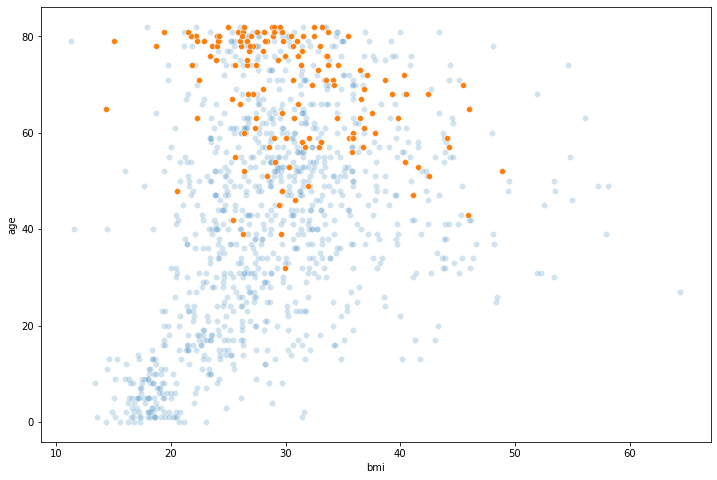

The scatterplot above shows Age on the y-axis and BMI on the x-axis.

The faint blue dots are considered 0's, or non-strokes, and the orange dots are considered 1's, or strokes.

Some relationships that the scatterplot shows is that:
1. the higher the age the higher the amounts of strokes.
2. a BMI between 20 to 38 has a higher amount of strokes than other BMIs.


In [7]:
# 3 (2) Explatory data analysis using scatterplots:
plt.figure(figsize = (12,8))
ax = sns.scatterplot(x="bmi", y="age", alpha=0.2, data=df[df['target']==0])
sns.scatterplot(x = "bmi", y="age", alpha=1, data=df[df['target']==1], ax=ax)
plt.show()
print("The scatterplot above shows Age on the y-axis and BMI on the x-axis.")
print("\nThe faint blue dots are considered 0's, or non-strokes, and the orange dots are considered 1's, or strokes.")
print("\nSome relationships that the scatterplot shows is that:")
print("1. the higher the age the higher the amounts of strokes.")
print("2. a BMI between 20 to 38 has a higher amount of strokes than other BMIs.")

In [8]:
# 3 Dropping column 'id'
df = df.drop(['id'],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1136 entries, 0 to 1135
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             1136 non-null   object 
 1   age                1136 non-null   int64  
 2   hypertension       1136 non-null   int64  
 3   heart_disease      1136 non-null   int64  
 4   ever_married       1136 non-null   object 
 5   work_type          1136 non-null   object 
 6   Residence_type     1136 non-null   object 
 7   avg_glucose_level  1136 non-null   float64
 8   bmi                1136 non-null   float64
 9   smoking_status     1136 non-null   object 
 10  target             1136 non-null   int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 97.8+ KB


In [9]:
# 3 Using value_counts() to see range of values for each column
for column in df:
    print(df[column].value_counts())
print("\nTarget variable is not balanced, its around a 10 to 1 ratio in terms of data")
print("\nWork_type shows one type called Never_worked that only has two values, dropping due to being too little of a sample")

Female    642
Male      494
Name: gender, dtype: int64
79    26
57    24
78    24
52    23
55    22
      ..
46     7
6      7
22     7
12     6
4      6
Name: age, Length: 83, dtype: int64
0    1001
1     135
Name: hypertension, dtype: int64
0    1058
1      78
Name: heart_disease, dtype: int64
Yes    769
No     367
Name: ever_married, dtype: int64
Private          671
Self-employed    174
children         147
Govt_job         142
Never_worked       2
Name: work_type, dtype: int64
Urban    587
Rural    549
Name: Residence_type, dtype: int64
92.14     3
94.92     2
203.81    2
72.09     2
76.12     2
         ..
232.81    1
100.09    1
114.76    1
77.77     1
108.61    1
Name: avg_glucose_level, Length: 1068, dtype: int64
26.1    13
31.4    13
35.9    13
28.7    12
26.4    12
        ..
58.1     1
56.1     1
15.5     1
54.6     1
49.4     1
Name: bmi, Length: 308, dtype: int64
never smoked       416
Unknown            352
formerly smoked    204
smokes             164
Name: smoking_stat

In [10]:
# 3 Dropping value "Never_worked" in work_type
print(df.shape)
df = df[df['work_type']!="Never_worked"]
print(df['work_type'].value_counts())
print(df.shape)

(1136, 11)
Private          671
Self-employed    174
children         147
Govt_job         142
Name: work_type, dtype: int64
(1134, 11)


               age          bmi  avg_glucose_level
count  1134.000000  1134.000000        1134.000000
mean     45.261023    29.207760         107.677222
std      23.056336     7.626362          47.657929
min       0.000000    11.300000          55.270000
25%      28.000000    24.100000          77.540000
50%      48.000000    28.500000          91.870000
75%      63.000000    33.300000         113.847500
max      82.000000    64.400000         266.590000
AxesSubplot(0.125,0.125;0.775x0.755)


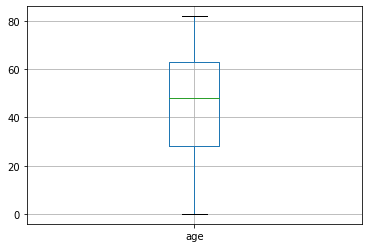

In [11]:
# 3 (2) Checking for outliers in numerical features:
print(df.describe()[['age','bmi','avg_glucose_level']])
print(df.boxplot(['age']))

AxesSubplot(0.125,0.125;0.775x0.755)
Due to bmi being a natural variation within the dataset, not dropping outliers


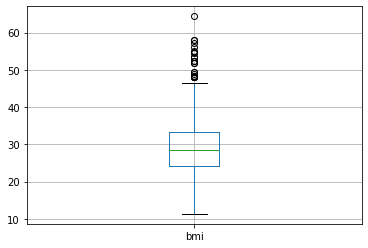

In [12]:
# 3 (2) Checking for outliers in numerical features:
print(df.boxplot(['bmi']))
print("Due to bmi being a natural variation within the dataset, not dropping outliers")

AxesSubplot(0.125,0.125;0.775x0.755)
Due to avg_glucose_level being a natural variation within the dataset, not dropping outliers


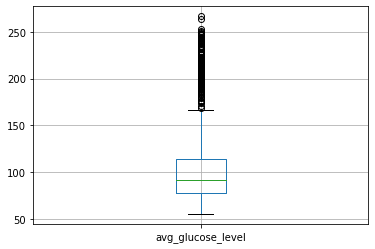

In [13]:
# 3 (2) Checking for outliers in numerical features:
print(df.boxplot(['avg_glucose_level']))
print("Due to avg_glucose_level being a natural variation within the dataset, not dropping outliers")

Features that show significant variance are age and avg_glucose_level. Feature that show slight variance is bmi.


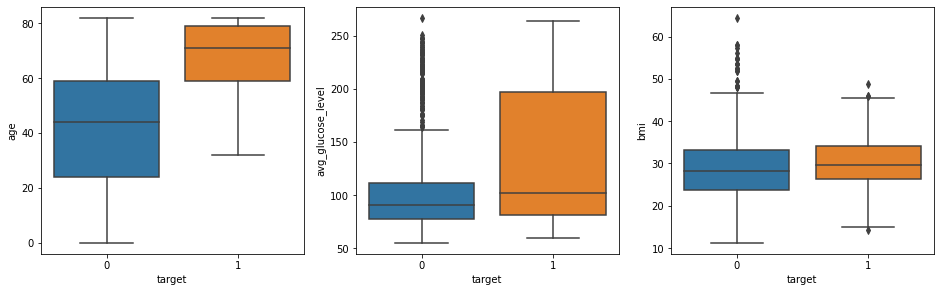

In [14]:
# 3 (2) Generating boxplots for all numerical features vs. the target variable
num_list=['age','avg_glucose_level','bmi']
fig=plt.figure(figsize=(16, 10))
for i in range(len(num_list)):
    column=num_list[i]
    sub=fig.add_subplot(2,3,i+1)
    sns.boxplot(x='target',y=column, data=df)
print("Features that show significant variance are age and avg_glucose_level.", "Feature that show slight variance is bmi.")

In [15]:
# 3 (2) ANOVA f-test
x = df.loc[:, num_list]
y = df.loc[:, 'target']
fs = SelectKBest(score_func=f_classif, k='all')
bestFeatures = fs.fit(x, y)
np.set_printoptions(suppress = True)
print(bestFeatures.scores_)
print(bestFeatures.pvalues_)

[184.59176353  40.03408174   4.95228647]
[0.         0.         0.02625261]


Gender chart indicates that females have a lower chance of strokes than males.
Heart disease chart indicates that people with previous heart disease have a significantly higher chance of getting a stroke   compared to people without heart disease.


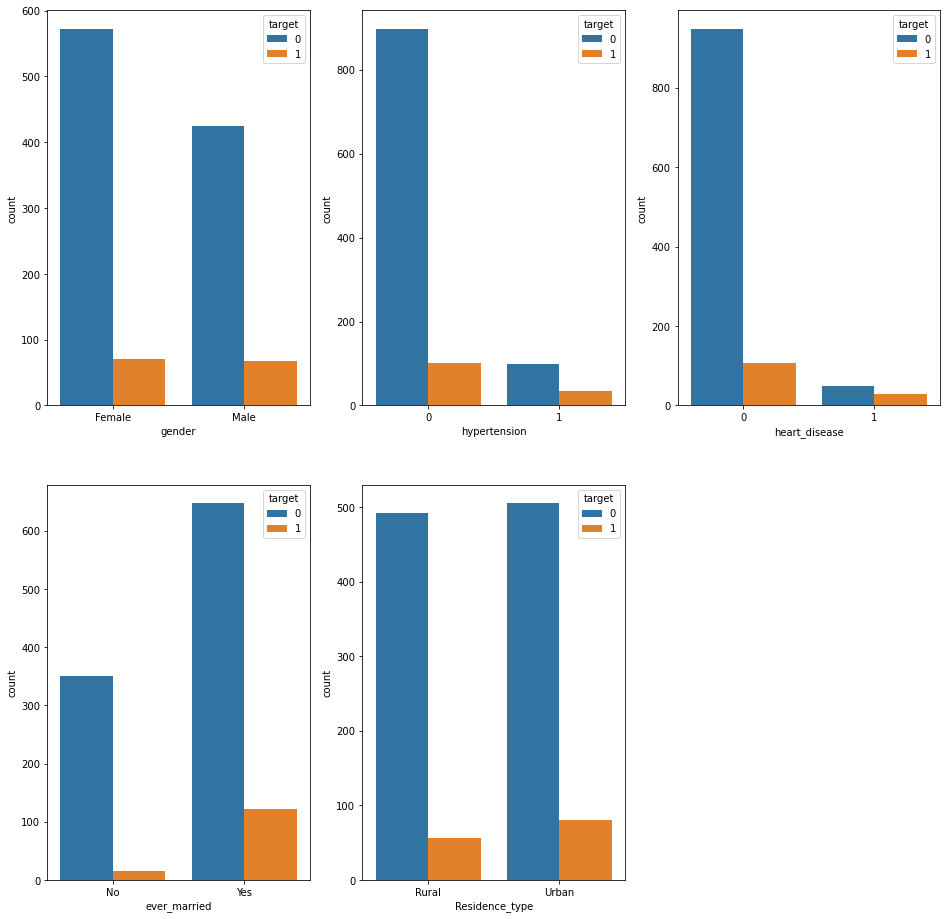

In [16]:
# 3 Grouped barplots for each categorial feature
cat_list=['gender','hypertension','heart_disease','ever_married','Residence_type']
fig=plt.figure(figsize=(16,16))
for i in range(len(cat_list)):
    column=cat_list[i]
    sub=fig.add_subplot(2,3,i+1)
    chart=sns.countplot(x=column, hue='target', data=df)
print("Gender chart indicates that females have a lower chance of strokes than males.")
print("Heart disease chart indicates that people with previous heart disease have a significantly higher chance of",
      "getting a stroke   compared to people without heart disease.")

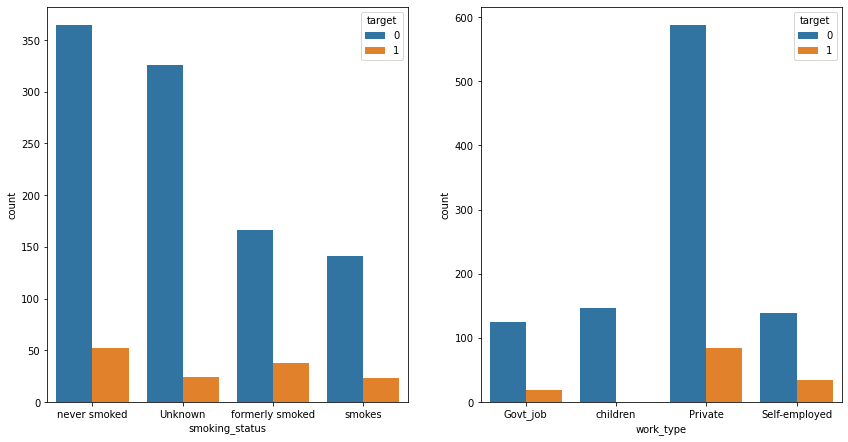

In [17]:
# 3 Other grouped barplots for categorical features that need some enlargement that make them easier to read.
cat_list=['smoking_status','work_type']
fig=plt.figure(figsize=(22,16))
for i in range(len(cat_list)):
    column=cat_list[i]
    sub=fig.add_subplot(2,3,i+1)
    chart=sns.countplot(x=column, hue='target', data=df)


In [18]:
# 3 (2) Converting categorical variables to numerical (For chi-squared test).
worklist={'Govt_job':0,'children':1,'Private':2,'Self-employed':3,'Never_worked':4}
df=df.replace(worklist)
print(df['work_type'].value_counts())
print(worklist,"\n")

smokelist={'never smoked':0, 'Unknown':1,'formerly smoked':2,'smokes':3}
df=df.replace(smokelist)
print(df['smoking_status'].value_counts())
print(smokelist,"\n")

genderlist={'Female':0,'Male':1}
df=df.replace(genderlist)
print(df['gender'].value_counts())
print(genderlist,"\n")

residencelist={'Urban':0,'Rural':1}
df=df.replace(residencelist)
print(df['Residence_type'].value_counts())
print(residencelist,"\n")

marrylist={'No':0,'Yes':1}
df=df.replace(marrylist)
print(df['ever_married'].value_counts())
print(marrylist,"\n")

2    671
3    174
1    147
0    142
Name: work_type, dtype: int64
{'Govt_job': 0, 'children': 1, 'Private': 2, 'Self-employed': 3, 'Never_worked': 4} 

0    416
1    350
2    204
3    164
Name: smoking_status, dtype: int64
{'never smoked': 0, 'Unknown': 1, 'formerly smoked': 2, 'smokes': 3} 

0    642
1    492
Name: gender, dtype: int64
{'Female': 0, 'Male': 1} 

0    586
1    548
Name: Residence_type, dtype: int64
{'Urban': 0, 'Rural': 1} 

1    769
0    365
Name: ever_married, dtype: int64
{'No': 0, 'Yes': 1} 



In [19]:
# 3 (2) Using chi-squared test to see the dependance of each categorical feature and the target, using p-value to drop certain variables.
catlist=['gender','hypertension','heart_disease','ever_married','work_type','Residence_type','smoking_status']
x = df.loc[:, catlist]
y = df.loc[:, 'target']

chi = SelectKBest(score_func=chi2, k='all')
catFeatures = chi.fit(x, y)
print("Features",catlist)
print("Scores",catFeatures.scores_)
print("P-values",catFeatures.pvalues_)
print("\nFeatures to be dropped (p-value larger than 0.05):"," Gender, Work_type, Residence_type, and smoking status")

Features ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
Scores [ 1.09392143 24.36224733 46.25893402 10.36463947  4.22711373  1.78904212
  2.43648795]
P-values [0.29560398 0.0000008  0.         0.00128452 0.03978304 0.18104291
 0.11854137]

Features to be dropped (p-value larger than 0.05):  Gender, Work_type, Residence_type, and smoking status


In [20]:
# 3 Dropping features listed above
df = df.drop(['work_type','Residence_type','smoking_status','gender'],axis=1)

In [21]:
# 3
x = df.loc[:, df.columns!='target']
y = df['target']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, stratify=y)

In [22]:
# 3 Oversampling data
os = SMOTE(random_state=2)
oversampled_x,oversampled_y=os.fit_resample(x_train, y_train)
print(x_train.shape)
print(oversampled_x.shape)

(793, 6)
(1394, 6)


Accuracy score: 0.750733137829912
              precision    recall  f1-score   support

           0       0.94      0.77      0.84       300
           1       0.27      0.61      0.37        41

    accuracy                           0.75       341
   macro avg       0.60      0.69      0.61       341
weighted avg       0.85      0.75      0.79       341



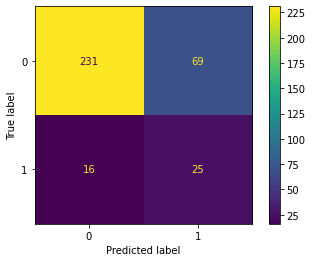

In [23]:
# 3 Oversampled Regression
LogRegression = LogisticRegression(penalty='none', max_iter=2000)
LogRegression.fit(oversampled_x, oversampled_y.values.ravel())
test_pred = LogRegression.predict(x_test)
print("Accuracy score:" ,accuracy_score(y_test, test_pred))
report = classification_report(y_test, test_pred)
print(report)
ConfusionMatrixDisplay.from_estimator(LogRegression, x_test, y_test)

In [27]:
# 3 (1) Oversampled Standardization w/ Forest Classifier Pipeline
pipeline = make_pipeline(StandardScaler(), RandomForestClassifier())
pipeline.fit(oversampled_x.values, oversampled_y.values.ravel())
prediction = pipeline.predict(x_test)

print(f"Accuracy Score : {round(accuracy_score(y_test, prediction) * 100, 2)}%")

report = classification_report(y_test, prediction)
print(report)

Accuracy Score : 81.82%
              precision    recall  f1-score   support

           0       0.92      0.87      0.89       300
           1       0.31      0.41      0.35        41

    accuracy                           0.82       341
   macro avg       0.61      0.64      0.62       341
weighted avg       0.84      0.82      0.83       341



D:\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [28]:
# 4 
pickle.dump(pipeline, open("model.pkl", "wb"))